In [2]:
#Note: before launching Jupyter lab, need to export: export DJANGO_SETTINGS_MODULE=crypto_signal.settings
import django
django.setup()

In [3]:
from crypto_track.models import CryptoCandle, PyTrends, Bank, SignalSimulation, Simulation
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [4]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("db.sqlite3")
df = pd.read_sql_query("select a.*, b.trend_ratio from crypto_track_cryptocandle as a left join crypto_track_pytrends as b on a.search_trend_id = b.date order by period_start_timestamp;", conn)
df.head()

,id,crypto_traded,currency_quoted,period_interval,period_start_timestamp,period_low,period_open,period_close,period_high,period_volume,data_source,search_trend_id,update_timestamp,trend_ratio
0,21227,BTC,USD,1d,2013-01-14T00:00:00Z,14.53295,14.53737,14.53295,14.53737,295,Nomics https://api.nomics.com/v1/candles,2013-01-14,2018-11-28 15:39:20.146682,0.6
1,21228,BTC,USD,1d,2013-01-15T00:00:00Z,14.52479,14.52479,14.76857,14.76857,945,Nomics https://api.nomics.com/v1/candles,2013-01-15,2018-11-28 15:39:20.146682,NaN
2,21229,BTC,USD,1d,2013-01-16T00:00:00Z,14.74920,14.74920,15.02460,15.02460,2419,Nomics https://api.nomics.com/v1/candles,2013-01-16,2018-11-28 15:39:20.146682,2.0
3,21230,BTC,USD,1d,2013-01-17T00:00:00Z,15.13679,15.13679,15.96468,15.96468,8011,Nomics https://api.nomics.com/v1/candles,2013-01-17,2018-11-28 15:39:20.146682,NaN
4,21231,BTC,USD,1d,2013-01-18T00:00:00Z,15.74880,16.03437,15.99800,16.26278,5762,Nomics https://api.nomics.com/v1/candles,2013-01-18,2018-11-28 15:39:20.146682,NaN


In [5]:
from django.shortcuts import get_object_or_404
# attach next day's close price so we can estimate
candle_data = list(CryptoCandle.objects.all().values().order_by('-period_start_timestamp'))
next_candle = ""
for i, cd in enumerate(candle_data):
    
    try:
        candle = get_object_or_404(CryptoCandle, pk=cd['id'])
        tr = candle.search_trend.trend_ratio
    except:
        tr = None
        
    candle_data[i]['trend_ratio'] = tr
    candle_data[i]['next_candle_period_close'] = next_candle
    next_candle = candle_data[i]['period_close']

In [6]:
print(candle_data[0])

{'id': 23371, 'crypto_traded': 'BTC', 'currency_quoted': 'USD', 'period_interval': '1d', 'period_start_timestamp': '2018-11-28T00:00:00Z', 'search_trend_id': None, 'period_low': Decimal('3610.0268500000'), 'period_open': Decimal('3820.5839900000'), 'period_close': Decimal('4217.6785300000'), 'period_high': Decimal('4343.7308900000'), 'period_volume': Decimal('1147997835.0000000000'), 'data_source': 'Nomics https://api.nomics.com/v1/candles', 'update_timestamp': datetime.datetime(2018, 11, 28, 15, 39, 20, 146682, tzinfo=<UTC>), 'trend_ratio': None, 'next_candle_period_close': ''}


In [7]:
del candle_data[0]

In [8]:
# sort by start date ascending
candle_data.sort(key=lambda item: item['period_start_timestamp'])

In [9]:
print(candle_data[0])

{'id': 21227, 'crypto_traded': 'BTC', 'currency_quoted': 'USD', 'period_interval': '1d', 'period_start_timestamp': '2013-01-14T00:00:00Z', 'search_trend_id': datetime.date(2013, 1, 14), 'period_low': Decimal('14.5329500000'), 'period_open': Decimal('14.5373700000'), 'period_close': Decimal('14.5329500000'), 'period_high': Decimal('14.5373700000'), 'period_volume': Decimal('295.0000000000'), 'data_source': 'Nomics https://api.nomics.com/v1/candles', 'update_timestamp': datetime.datetime(2018, 11, 28, 15, 39, 20, 146682, tzinfo=<UTC>), 'trend_ratio': Decimal('0.60000'), 'next_candle_period_close': Decimal('14.7685700000')}


In [10]:
df = pd.DataFrame(candle_data)
df.head()

,crypto_traded,currency_quoted,data_source,id,next_candle_period_close,period_close,period_high,period_interval,period_low,period_open,period_start_timestamp,period_volume,search_trend_id,trend_ratio,update_timestamp
0,BTC,USD,Nomics https://api.nomics.com/v1/candles,21227,14.7685700000,14.5329500000,14.5373700000,1d,14.5329500000,14.5373700000,2013-01-14T00:00:00Z,295.0000000000,2013-01-14,0.60000,2018-11-28 15:39:20.146682+00:00
1,BTC,USD,Nomics https://api.nomics.com/v1/candles,21228,15.0246000000,14.7685700000,14.7685700000,1d,14.5247900000,14.5247900000,2013-01-15T00:00:00Z,945.0000000000,2013-01-15,None,2018-11-28 15:39:20.146682+00:00
2,BTC,USD,Nomics https://api.nomics.com/v1/candles,21229,15.9646800000,15.0246000000,15.0246000000,1d,14.7492000000,14.7492000000,2013-01-16T00:00:00Z,2419.0000000000,2013-01-16,2.00000,2018-11-28 15:39:20.146682+00:00
3,BTC,USD,Nomics https://api.nomics.com/v1/candles,21230,15.9980000000,15.9646800000,15.9646800000,1d,15.1367900000,15.1367900000,2013-01-17T00:00:00Z,8011.0000000000,2013-01-17,None,2018-11-28 15:39:20.146682+00:00
4,BTC,USD,Nomics https://api.nomics.com/v1/candles,21231,15.9273000000,15.9980000000,16.2627800000,1d,15.7488000000,16.0343700000,2013-01-18T00:00:00Z,5762.0000000000,2013-01-18,None,2018-11-28 15:39:20.146682+00:00


In [11]:
df.dtypes

crypto_traded                            object
currency_quoted                          object
data_source                              object
id                                        int64
next_candle_period_close                 object
period_close                             object
period_high                              object
period_interval                          object
period_low                               object
period_open                              object
period_start_timestamp                   object
period_volume                            object
search_trend_id                          object
trend_ratio                              object
update_timestamp            datetime64[ns, UTC]
dtype: object

In [12]:
import numpy as np
df.replace( '',np.nan, regex=True)
df['period_close'] = df.period_close.astype(float)
df['period_high'] = df.period_high.astype(float)
df['period_low'] = df.period_low.astype(float)
df['period_open'] = df.period_open.astype(float)
df['period_volume'] = df.period_volume.astype(float)
df['next_candle_period_close'] = df.next_candle_period_close.astype(float)
df['trend_ratio'] = df.trend_ratio.astype(float)
# df = df[(len(df.next_candle_period_close) > 0)]
#df['next_candle_period_close'] = df.next_candle_period_close.astype(float)
df.dtypes


crypto_traded                            object
currency_quoted                          object
data_source                              object
id                                        int64
next_candle_period_close                float64
period_close                            float64
period_high                             float64
period_interval                          object
period_low                              float64
period_open                             float64
period_start_timestamp                   object
period_volume                           float64
search_trend_id                          object
trend_ratio                             float64
update_timestamp            datetime64[ns, UTC]
dtype: object

In [13]:
df.describe()

,id,next_candle_period_close,period_close,period_high,period_low,period_open,period_volume,trend_ratio
count,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,2.144000e+03,2133.000000
mean,22298.500000,2172.439836,2170.479413,2389.488842,1835.782307,2168.967872,6.576478e+08,1.053718
std,619.063809,3370.153821,3370.186036,4651.347783,2736.600724,3371.411521,1.750019e+09,1.227227
min,21227.000000,14.768570,14.532950,14.537370,0.010000,14.524790,2.950000e+02,0.173910
25%,21762.750000,273.717835,273.235800,304.807163,260.000007,272.688993,2.313262e+06,0.420000
50%,22298.500000,580.617880,580.338285,601.082770,543.300620,580.065015,1.602612e+07,0.568180
75%,22834.250000,2392.712435,2386.243825,2646.688500,1940.276093,2352.864360,3.723883e+08,1.000000
max,23370.000000,19409.628430,19409.628430,136401.827730,15377.620880,19393.650760,1.781027e+10,12.500000


In [28]:
df.to_csv('ml_output.csv')

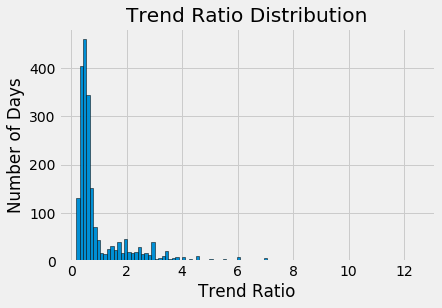

In [14]:
import matplotlib.pyplot as plt
# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(df['trend_ratio'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Trend Ratio'); plt.ylabel('Number of Days'); 
plt.title('Trend Ratio Distribution');

In [19]:
df_nona = df.dropna(subset=['trend_ratio'])

In [20]:
df_nona.head()

,crypto_traded,currency_quoted,data_source,id,next_candle_period_close,period_close,period_high,period_interval,period_low,period_open,period_start_timestamp,period_volume,search_trend_id,trend_ratio,update_timestamp
0,BTC,USD,Nomics https://api.nomics.com/v1/candles,21227,14.76857,14.53295,14.53737,1d,14.53295,14.53737,2013-01-14T00:00:00Z,295.0,2013-01-14,0.6,2018-11-28 15:39:20.146682+00:00
2,BTC,USD,Nomics https://api.nomics.com/v1/candles,21229,15.96468,15.02460,15.02460,1d,14.74920,14.74920,2013-01-16T00:00:00Z,2419.0,2013-01-16,2.0,2018-11-28 15:39:20.146682+00:00
5,BTC,USD,Nomics https://api.nomics.com/v1/candles,21232,16.10570,15.92730,16.05480,1d,15.63659,16.00379,2013-01-19T00:00:00Z,3541.0,2013-01-19,3.0,2018-11-28 15:39:20.146682+00:00
6,BTC,USD,Nomics https://api.nomics.com/v1/candles,21233,17.13600,16.10570,16.16697,1d,15.84432,15.84432,2013-01-20T00:00:00Z,392.0,2013-01-20,3.0,2018-11-28 15:39:20.146682+00:00
7,BTC,USD,Nomics https://api.nomics.com/v1/candles,21234,17.74800,17.13600,17.13600,1d,16.09445,16.09445,2013-01-21T00:00:00Z,2618.0,2013-01-21,1.0,2018-11-28 15:39:20.146682+00:00


In [21]:
df_nona.describe()

,id,next_candle_period_close,period_close,period_high,period_low,period_open,period_volume,trend_ratio
count,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2.133000e+03,2133.000000
mean,22301.919362,2179.766335,2178.003071,2397.725351,1841.993661,2176.402918,6.595306e+08,1.053718
std,616.026120,3375.467905,3375.610089,4660.443991,2740.713009,3376.800336,1.753751e+09,1.227227
min,21227.000000,14.768570,14.532950,14.537370,0.010000,14.537370,2.950000e+02,0.173910
25%,21769.000000,276.247250,276.219440,307.068780,262.000000,275.492360,2.359437e+06,0.420000
50%,22302.000000,581.467240,581.124220,603.454070,547.396270,581.052670,1.608188e+07,0.568180
75%,22835.000000,2397.176510,2391.224410,2646.688500,1950.000000,2384.057430,3.727769e+08,1.000000
max,23368.000000,19409.628430,19409.628430,136401.827730,15377.620880,19393.650760,1.781027e+10,12.500000


In [22]:
# Create target object and call it y
y = df_nona.next_candle_period_close

In [23]:
features = ['period_close', 'period_high', 'period_low', 'period_open', 'period_volume', 'trend_ratio']
X = df_nona[features]

In [24]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [25]:
# Specify Model
btc_model = DecisionTreeRegressor(random_state=1)
# Fit Model
btc_model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [26]:
# Make validation predictions and calculate mean absolute error
val_predictions = btc_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

Validation MAE when not specifying max_leaf_nodes: 114


In [27]:
val_predictions

array([8.27321829e+03, 8.15405470e+02, 8.06996829e+03, 1.23531720e+02,
       2.39351560e+02, 1.25740267e+03, 3.25346050e+02, 3.92575300e+02,
       2.38330090e+02, 3.23785360e+02, 4.64069390e+02, 5.60838200e+02,
       1.03257613e+03, 4.36051418e+03, 3.78286300e+02, 1.23653680e+02,
       1.08854419e+03, 6.63043330e+02, 7.11050981e+03, 2.51768154e+03,
       2.29589910e+02, 4.42600530e+02, 9.74000000e+01, 2.54738920e+02,
       5.60838200e+02, 6.01215180e+02, 1.16721865e+04, 5.95309180e+02,
       6.21120040e+02, 6.14522490e+02, 2.95211050e+02, 3.92425790e+02,
       9.78882350e+02, 6.12991850e+02, 3.29381580e+02, 2.47724670e+02,
       4.57880430e+02, 4.55530880e+02, 6.22627760e+02, 6.52261410e+02,
       6.44004400e+01, 2.72365740e+02, 9.84585020e+02, 5.81124220e+02,
       3.29361820e+02, 6.57593717e+03, 2.36677940e+02, 2.50019853e+03,
       7.43925170e+02, 1.47321370e+04, 2.35851780e+02, 2.30277510e+02,
       1.09520000e+02, 2.75428810e+02, 1.43484000e+02, 9.21798550e+02,
      